# Agreed Parameters
c (rate of infection) = 0.2 for all

gamma (rate of recovery) = 0.1 for all

beta_bb = 0.6

beta_ww = 0.1

beta_bw = 0.3

beta_wb = 0.2

death = [0.005] for all

death = [0.005, 0.007, 0.01] (White, Blue, Stay at Home) makes it more interesting

In [16]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

In [17]:
def sir_system_implicit(vars, S_prev, I_prev, R_prev, D_prev, beta, gamma, Z, mu, c, dt):
    S_new, I_new, R_new, D_new = vars[0:2], vars[2:4], vars[4:6], vars[6:8]
    S_prev, I_prev, R_prev, D_prev = np.array(S_prev), np.array(I_prev), np.array(R_prev), np.array(D_prev)
    F = np.zeros(8)
    F[0:2] = S_new - S_prev - dt * -(beta @ I_new * S_new * c - mu * R_new)
    F[2:4] = I_new - I_prev - dt * (beta @ I_new * S_new * c - gamma * I_new - Z * I_new)
    F[4:6] = R_new - R_prev - dt * (gamma * I_new - mu * R_new)
    F[6:8] = D_new - D_prev - dt * Z * I_new
    return F

In [18]:
def sir_model_implicit_euler_matrix(S0, I0, R0, D0, beta, gamma, dt, Z, mu, T, c):
    # Initial conditions
    S = np.array(S0)
    I = np.array(I0)
    R = np.array(R0)
    D = np.array(D0)


    num_steps = int(T / dt)

    # Lists to store results
    S_list = [S]
    I_list = [I]
    R_list = [R]
    D_list = [D]
    for i in range(num_steps):
        S_prev = S
        I_prev = I
        R_prev = R
        D_prev = D

        # Solve the implicit Euler equations; this function is literally a black box to me I just found
        # someone else who implemented it on stack overflow and did what they did
        sol = opt.root(sir_system_implicit, np.concatenate((S, I, R, D)), args=(S_prev, I_prev, R_prev, D_prev, beta, gamma, Z, mu, c, dt))
        sol = sol.x

        # Update state variables
        S, I, R, D = sol[0:2], sol[2:4], sol[4:6], sol[6:8]
        S_list.append(S)
        I_list.append(I)
        R_list.append(R)
        D_list.append(D)

    S_list = np.array(S_list)
    I_list = np.array(I_list)
    R_list = np.array(R_list)
    D_list = np.array(D_list)
    return S_list, I_list, R_list, D_list

In [19]:
S0 = [0.99, 0.99]  # Initial susceptible population [white collar, blue collar]
I0 = [0.01, 0.01]  # Initial infected population [white collar, blue collar]
R0 = [0.0, 0.0]    # Initial recovered population [white collar, blue collar]
D0 = [0.0, 0.0]    # Initial dead population [white collar, blue collar]

# Beta matrix with interaction rates, assuming interaction always causes infection, 
# Chance of an interaction with an infected person/day
beta = np.array([[0.1, 0.3],  # beta_ww, beta_wb
                 [0.2, 0.6]])  # beta_bw, beta_bb

# Infection Rate
# Chance of an interaction per interaction with an infected person
c = 0.6

# Chance of recovery per day of being infected
gamma = np.array([0.1, 0.1])  # Recovery rates [gamma_w, gamma_b, gamma_o]

# Death Rates
# Chance of death per day of being infected
Z = np.array([0.005, 0.007]) # White collar, Blue Collar


# Rates of immunity loss
# Chance of becoming susceptible per day of being recovered
mu = np.array([0.005, 0.005]) # White collar, Blue Collar


dt = 0.01  # Time step
T = 100  # Total time



S_list, I_list, R_list, D_list = sir_model_implicit_euler_matrix(S0, I0, R0, D0, beta, gamma, dt, Z, mu, T, c)

time = np.arange(0, T + dt, dt)

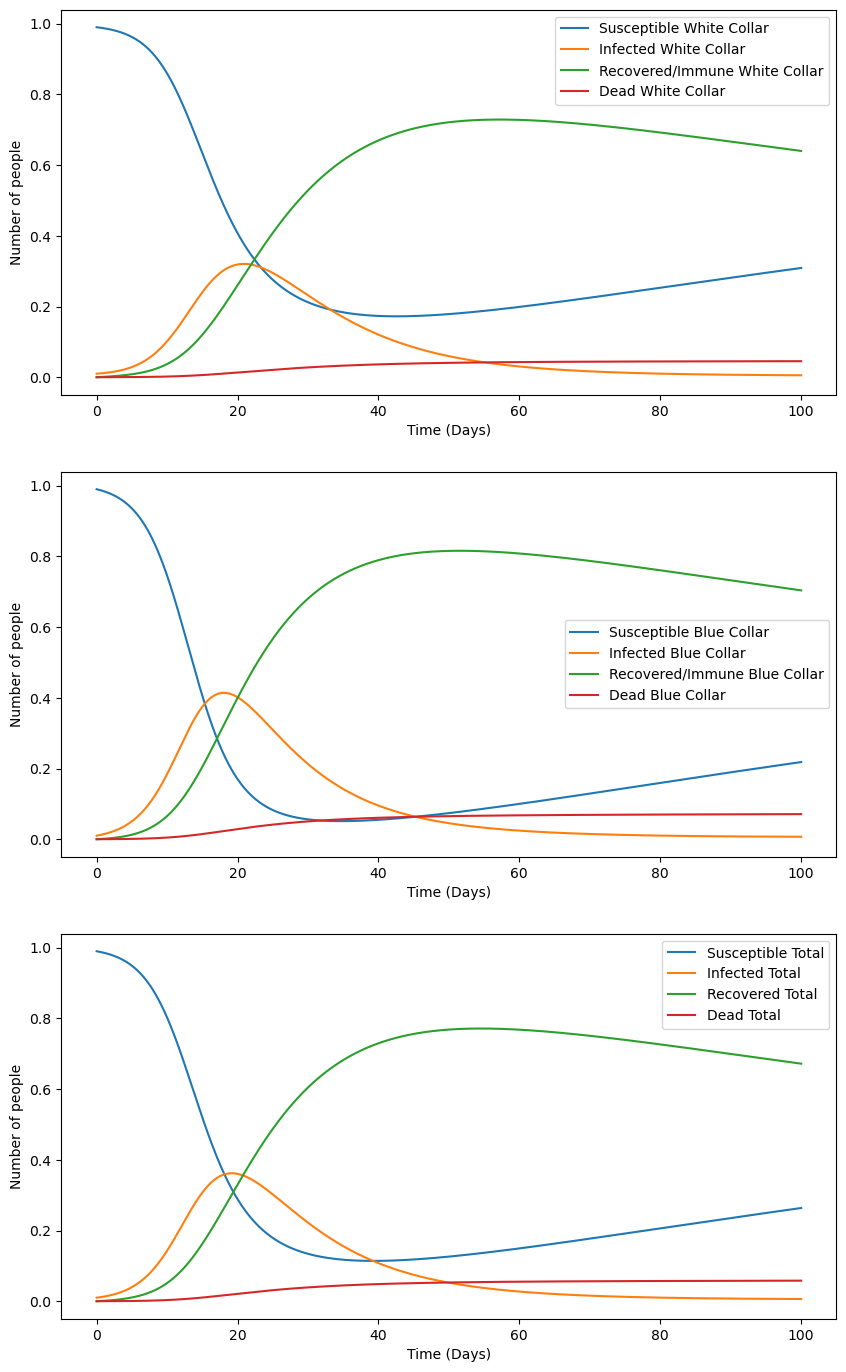

In [20]:
fig, ax = plt.subplots(3, 1, figsize=(10, 17))

ax[0].plot(time, S_list[:, 0], label='Susceptible White Collar')
ax[0].plot(time, I_list[:, 0], label='Infected White Collar')
ax[0].plot(time, R_list[:, 0], label='Recovered/Immune White Collar')
ax[0].plot(time, D_list[:, 0], label='Dead White Collar')
ax[1].plot(time, S_list[:, 1], label='Susceptible Blue Collar')
ax[1].plot(time, I_list[:, 1], label='Infected Blue Collar')
ax[1].plot(time, R_list[:, 1], label='Recovered/Immune Blue Collar')
ax[1].plot(time, D_list[:, 1], label='Dead Blue Collar')
ax[2].plot(time, np.sum(S_list[:,], 1)/2, label='Susceptible Total')
ax[2].plot(time, np.sum(I_list[:,], 1)/2, label='Infected Total')
ax[2].plot(time, np.sum(R_list[:,], 1)/2, label='Recovered Total')
ax[2].plot(time, np.sum(D_list[:,], 1)/2, label='Dead Total')

for i in range(3):
    ax[i].set_xlabel('Time (Days)')
    ax[i].set_ylabel('Number of people')
    ax[i].legend()

plt.show()

In [21]:
print("End: ")
print(f'White Collar: \n Susceptible: {S_list[:,0][-1]} \n Infected: {I_list[:,0][-1]} \n Recovered: {R_list[:,0][-1]}')
print(f'Blue Collar: \n Susceptible: {S_list[:,1][-1]} \n Infected: {I_list[:,1][-1]} \n Recovered: {R_list[:,1][-1]}')
print(f'Total: \n Suceptible: {np.sum(S_list[-1])/2} \n Infected: {np.sum(I_list[-1])/2} \n Recovered: {np.sum(R_list[-1])/2}')

print("")
print(f'Max infected:  \n White Collar: {np.max(I_list[:,0])} \n Blue Collar: {np.max(I_list[:,1])} \n Total: {np.max(I_list[:,0] + I_list[:,1]/2)}') 

End: 
White Collar: 
 Susceptible: 0.30905355278508556 
 Infected: 0.00552798713708813 
 Recovered: 0.6400627266761652
Blue Collar: 
 Susceptible: 0.21822454562911292 
 Infected: 0.006977079616616471 
 Recovered: 0.7038487673633642
Total: 
 Suceptible: 0.26363904920709924 
 Infected: 0.0062525333768523005 
 Recovered: 0.6719557470197647

Max infected:  
 White Collar: 0.32057927761056126 
 Blue Collar: 0.4141345025333052 
 Total: 0.5201206884690189
